# Import Libraries

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from optuna.samplers import TPESampler
import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time
import xgboost as xgb

In [4]:
# !pip install mrmr-selection

In [5]:
# from mrmr import mrmr_classif

In [24]:
# Load the features dataset
df_features = pd.read_csv('/kaggle/input/skin-cancer-binary-v2/features_dataset_full_v3.csv')

# Separate features and labels
X = df_features.drop('label', axis=1)
y = df_features['label']

In [25]:
df_features.shape

(15195, 843)

In [26]:
df_features_valid = pd.read_csv('/kaggle/input/skin-cancer-binary-v2/features_dataset_valid_v3.csv')
X_valid = df_features_valid.drop('label', axis=1)
y_valid = df_features_valid['label']

In [27]:
df_features_valid.shape

(3796, 843)

In [28]:
X_test = pd.read_csv('/kaggle/input/skin-cancer-binary-v2/features_dataset_test_v3.csv')

In [29]:
X_test.shape

(6340, 842)

In [5]:
# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Utility functions for Preprocessing, Training and Evaluation

In [30]:
def preprocess_data(X, y, test_size=0.2, random_state=42, use_power_transformer=False):
    """
    Preprocess the data by splitting, encoding, and scaling.

    Parameters:
    - X: Features (input data).
    - y: Labels (target data).
    - test_size: Proportion of the dataset to include in the test split.
    - random_state: Seed for random number generator.
    - use_power_transformer: Boolean, whether to apply PowerTransformer to make the data more Gaussian-like.

    Returns:
    - X_train_scaled, X_test_scaled: Scaled feature data for training and testing.
    - y_train_encoded, y_test_encoded: Encoded labels for training and testing.
    - label_encoder: The label encoder used for encoding/decoding class labels.
    - scaler: The scaler or transformer used for feature scaling.
    """

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Apply scaling or PowerTransformer
    if use_power_transformer:
        transformer = PowerTransformer(method='yeo-johnson', standardize=True)
        X_train_scaled = transformer.fit_transform(X_train)
        X_test_scaled = transformer.transform(X_test)
    else:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded, label_encoder, transformer if use_power_transformer else scaler


def train_model(model, X_train_scaled, y_train_encoded, param_grid=None, cv=3, scoring='accuracy'):
    """
    Train the model with the training data, using GridSearchCV if a param_grid is provided.

    Parameters:
    - model: The machine learning model to train.
    - X_train_scaled: Scaled training features.
    - y_train_encoded: Encoded labels for the training set.
    - param_grid: Dictionary of hyperparameters to search in GridSearchCV.
    - cv: Number of cross-validation folds (default is 5).
    - scoring: Scoring metric for GridSearchCV (default is 'accuracy').

    Returns:
    - best_model: The trained model (best model if using GridSearchCV).
    - best_params: Best parameters found by GridSearchCV (None if param_grid is not provided).
    - train_accuracy: Accuracy of the best model on the training set.
    """
    
    # Check if param_grid is provided for hyperparameter tuning
    if param_grid:
        # Wrap the model with GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train_encoded)
        
        # Get the best model and parameters
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best Parameters: {best_params}")
    else:
        # If no param_grid is provided, fit the model directly
        model.fit(X_train_scaled, y_train_encoded)
        best_model = model
        best_params = None
    
    # Calculate training accuracy to check for overfitting
    y_train_pred = best_model.predict(X_train_scaled)
    train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
    print(f"Training Accuracy of Best Model: {train_accuracy:.4f}")
    
    return best_model, best_params, train_accuracy


def evaluate_model(model, model_name, X_test_scaled, y_test_encoded, label_encoder):
    """
    Evaluate the trained model on the test data and display metrics.

    Parameters:
    - model: The trained machine learning model.
    - model_name: A string representing the model's name.
    - X_test_scaled: Scaled testing features.
    - y_test_encoded: Encoded labels for the testing set.
    - label_encoder: The label encoder used to decode class labels.

    Returns:
    - accuracy: The accuracy score of the model on the test set.
    - report: The classification report.
    - confusion: The confusion matrix.
    """
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Decode the predictions and true labels back to the original class labels
    y_pred_decoded = label_encoder.inverse_transform(y_pred)
    y_test_decoded = label_encoder.inverse_transform(y_test_encoded)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
    report = classification_report(y_test_decoded, y_pred_decoded)
    confusion = confusion_matrix(y_test_decoded, y_pred_decoded)
    
    # Display results
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(confusion)
    print("-" * 60)
    
    return accuracy, report, confusion

def train_and_evaluate_pipeline(model, model_name, X, y, test_size=0.2, random_state=42, use_power_transformer=False, param_grid=None):
    """
    Complete pipeline for preprocessing, training, and evaluating a model with optional GridSearchCV.

    Parameters:
    - model: The machine learning model to train.
    - model_name: A string representing the model's name.
    - X: Features (input data).
    - y: Labels (target data).
    - test_size: Proportion of the dataset to include in the test split.
    - random_state: Seed for random number generator.
    - use_power_transformer: Boolean, whether to apply PowerTransformer to make the data more Gaussian-like.
    - param_grid: Dictionary of hyperparameters for GridSearchCV (optional).

    Returns:
    - accuracy, report, confusion, best_params, train_accuracy: Evaluation metrics and hyperparameters.
    """
    
    # Start measuring the execution time
    strt = time.time()
    
    # Step 1: Preprocess the data
    X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded, label_encoder, transformer = preprocess_data(
        X, y, test_size, random_state, use_power_transformer=use_power_transformer
    )
    
    # Step 2: Train the model with GridSearchCV if param_grid is provided
    trained_model, best_params, train_accuracy = train_model(model, X_train_scaled, y_train_encoded, param_grid=param_grid)
    
    # Stop measuring the execution time
    end = time.time()
    print(f'Total Time for Training Model "{model_name}": {end - strt:.2f} seconds')
    
    # Step 3: Evaluate the model on the test set
    accuracy, report, confusion = evaluate_model(trained_model, model_name, X_test_scaled, y_test_encoded, label_encoder)
    
    # Print a comparison to check for overfitting
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    return accuracy, report, confusion, best_params

In [1]:
# # Initialize the models
# # Initialize the models
# models = {
#     "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
#     "Support Vector Machine": SVC(kernel='linear', random_state=42),
#     "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
#     "LightGBM": LGBMClassifier(random_state=42),
#     "Random Forest": RandomForestClassifier(
#     n_estimators=250,
#     max_depth=20,
#     min_samples_split=8,
#     min_samples_leaf=3,
#     max_features=0.5780093202212182,
#     criterion='log_loss',
#     random_state=42)
# }

# # Train and evaluate each model
# for model_name, model in models.items():
#     # Train the model
#     model.fit(X_train_scaled, y_train_encoded)
    
#     # Make predictions on the test set
#     y_pred = model.predict(X_test_scaled)

#     # Decode the predictions back to the original class labels
#     y_pred_decoded = label_encoder.inverse_transform(y_pred)
#     y_test_decoded = label_encoder.inverse_transform(y_test_encoded)
    
#     # Evaluate the model
#     accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
#     print(f"Model: {model_name}")
#     print(f"Accuracy: {accuracy:.4f}")
#     print("Classification Report:")
#     print(classification_report(y_test_decoded, y_pred_decoded))
#     print("Confusion Matrix:")
#     print(confusion_matrix(y_test_decoded, y_pred_decoded))
#     print("-" * 60)

# Feature Selection using Random Forest

In [31]:
model = RandomForestClassifier(n_estimators=250,
                        max_depth=20,
                        min_samples_split=20,
                        min_samples_leaf=3,
                        max_features=0.5780093202212182,
                        criterion='log_loss',
                        random_state=42)

# Run the pipeline with PowerTransformer and GridSearchCV
accuracy, report, confusion, training_accuracy = train_and_evaluate_pipeline(
    model=model,
    model_name="Random Forest",
    X=X,
    y=y,
    use_power_transformer=False,
)

Training Accuracy of Best Model: 0.9670
Total Time for Training Model "Random Forest": 309.31 seconds
Model: Random Forest
Accuracy: 0.8184
Classification Report:
              precision    recall  f1-score   support

       nevus       0.81      0.83      0.82      1545
      others       0.82      0.80      0.81      1494

    accuracy                           0.82      3039
   macro avg       0.82      0.82      0.82      3039
weighted avg       0.82      0.82      0.82      3039

Confusion Matrix:
[[1285  260]
 [ 292 1202]]
------------------------------------------------------------
Training Accuracy: 0.9670
Test Accuracy: 0.8184


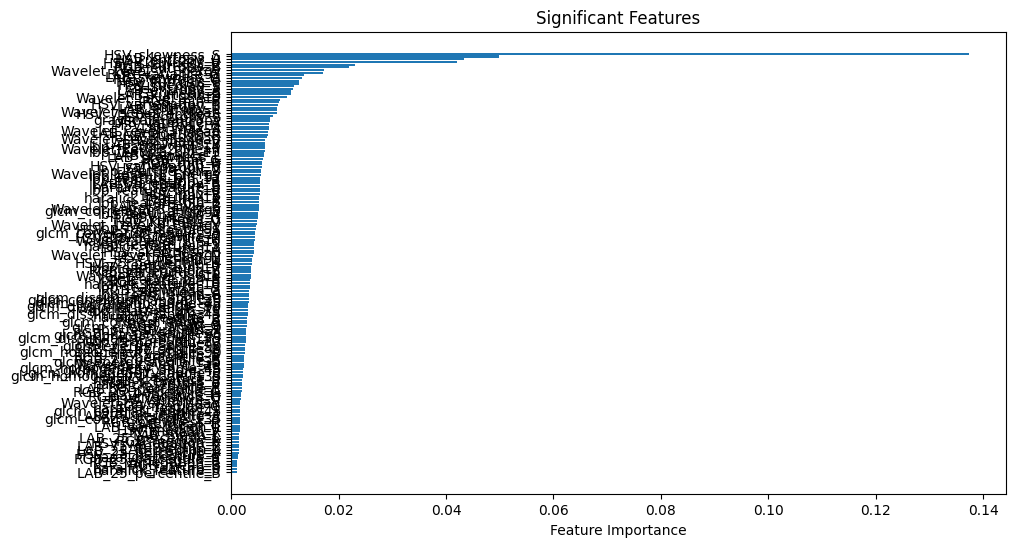

In [32]:
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})

# Set a threshold for significance (e.g., keep features with importance > 0.02)
significant_features = feature_importances[feature_importances['Importance'] > 0.001]

# Sort features by importance
significant_features = significant_features.sort_values(by='Importance', ascending=False)

# Visualize feature significance
plt.figure(figsize=(10, 6))
plt.barh(significant_features['Feature'], significant_features['Importance'])
plt.xlabel("Feature Importance")
plt.title("Significant Features")
plt.gca().invert_yaxis()
plt.show()

In [33]:
selected_features = list(significant_features['Feature'])

In [37]:
df_feature_full = pd.concat([df_features, df_features_valid], axis=0)

df_feature_selected = df_feature_full[selected_features]

df_feature_selected.shape

(18991, 156)

In [38]:
df = df_feature_selected.copy()
# df = df_feature_full.copy()
df['label'] = df_feature_full['label']
df.shape

(18991, 157)

In [39]:
df = df.sample(frac = 1).reset_index(drop=True)

df.head()

,HSV_skewness_S,LAB_kurtosis_A,HSV_entropy_H,HSV_skewness_V,RGB_kurtosis_B,RGB_entropy_B,Wavelet_Level_2_Energy,RGB_variance_G,LAB_skewness_A,RGB_entropy_G,...,LAB_25_percentile_A,HSV_25_percentile_V,haralick_feature_5,RGB_25_percentile_R,RGB_variegation_R,RGB_mean_B,haralick_feature_6,haralick_feature_3,LAB_25_percentile_B,label
0,20.139845,11.989286,4.765464,135.342461,17.053029,5.061887,5.503113e+06,46.521201,2.053079,4.528420,...,128.0,219.0,441.777338,218.0,0.097432,617.283070,2451.927691,616.165911,126.0,nevus
1,22.419629,1.174621,5.658604,367.673737,0.426999,6.187807,3.338374e+06,47.356082,4.723541,5.887133,...,128.0,171.0,370.151919,171.0,0.112997,830.266192,3261.695270,822.096492,128.0,others
2,67.375030,3.868825,5.854984,2570.425958,1.119504,6.581987,3.267947e+06,69.294477,8.614780,6.122764,...,126.0,191.0,394.538970,191.0,0.097038,612.305618,2424.419790,608.321670,126.0,others
3,32.839228,3.490088,5.212937,599.443162,1.079228,5.124013,1.817786e+06,44.985541,3.947960,4.778272,...,127.0,196.0,402.677367,193.0,0.093554,569.121464,2236.035197,563.775994,126.0,nevus
4,45.056574,-1.237825,5.500451,1743.798815,-1.576368,6.176003,4.904182e+06,83.111214,8.367974,6.114533,...,128.0,103.0,320.613974,103.0,0.253136,4166.661489,16550.202227,4150.702393,128.0,others


# Hyperparater tuning using GridSearchCV

In [40]:
X = df.drop('label', axis=1)
print(X.shape)
y = df['label']
y.shape

(18991, 156)


(18991,)

## Random Forest

In [ ]:
# # Initialize your model
# model = RandomForestClassifier()

# # Define the parameter grid for GridSearchCV
# param_grid = {
#     'n_estimators': [70, 250, 2000],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [13, 20],
#     'min_samples_split': [8],
#     'max_features': [0.5780093202212182]
# }

# # Run the pipeline with PowerTransformer and GridSearchCV
# accuracy, report, confusion, best_params = train_and_evaluate_pipeline(
#     model=model,
#     model_name="Random Forest with GridSearchCV",
#     X=X,
#     y=y,
#     use_power_transformer=False,
#     param_grid=param_grid
# )

# print("Best Parameters:", best_params)

In [28]:
# Initialize your model
model = RandomForestClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [70, 250, 2000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 13, 20],
    'min_samples_split': [8, 20],
    'max_features': [0.5780093202212182]
}

# Run the pipeline with PowerTransformer and GridSearchCV
accuracy, report, confusion, best_params = train_and_evaluate_pipeline(
    model=model,
    model_name="Random Forest with GridSearchCV",
    X=X,
    y=y,
    use_power_transformer=False,
    param_grid=param_grid
)

print("Best Parameters:", best_params)

Best Parameters: {'criterion': 'gini', 'max_depth': 13, 'max_features': 0.5780093202212182, 'min_samples_split': 8, 'n_estimators': 2000}
Training Accuracy of Best Model: 0.9494
Total Time for Training Model "Random Forest with GridSearchCV": 7122.39 seconds
Model: Random Forest with GridSearchCV
Accuracy: 0.7984
Classification Report:
              precision    recall  f1-score   support

       nevus       0.80      0.81      0.80      1932
      others       0.80      0.79      0.79      1867

    accuracy                           0.80      3799
   macro avg       0.80      0.80      0.80      3799
weighted avg       0.80      0.80      0.80      3799

Confusion Matrix:
[[1559  373]
 [ 393 1474]]
------------------------------------------------------------
Training Accuracy: 0.9494
Test Accuracy: 0.7984
Best Parameters: {'criterion': 'gini', 'max_depth': 13, 'max_features': 0.5780093202212182, 'min_samples_split': 8, 'n_estimators': 2000}


In [ ]:
# # Define the objective function for Optuna optimization
# def objective(trial, X_selected_scaled, y_encoded, X_selected_valid, y_valid_encoded):
#     # Define parameters to be optimized for the RandomForestClassifier
#     param = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 500),
#         "max_depth": trial.suggest_int("max_depth", 5, 20),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
#         "max_features": trial.suggest_float("max_features", 0.5, 1.0),
#         "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
#         "random_state": 42
#     }

#     # Initialize the RandomForestClassifier with the suggested parameters
#     rf_classifier = RandomForestClassifier(**param)
#     rf_classifier.fit(X_selected_scaled, y_encoded)
    
#     # Predict and calculate accuracy
#     y_pred = rf_classifier.predict(X_selected_valid)
#     accuracy = accuracy_score(y_valid_encoded, y_pred)
    
#     # Return the negative accuracy since Optuna minimizes by default
#     return 1-accuracy

# # Set up the Optuna study to maximize accuracy
# sampler = TPESampler(seed=42)
# study = optuna.create_study(direction="minimize", sampler=sampler)  # Change direction to "minimize" for accuracy
# study.optimize(lambda trial: objective(trial, X_selected_scaled, y_encoded, X_selected_valid, y_valid_encoded), n_trials=20)

# # Best parameters after optimization
# best_params = study.best_params
# print('='*20)
# print("Optimized parameters:", best_params)

## XGBoost

In [16]:
# Initialize your model
model = XGBClassifier(learning_rate=0.5, n_estimators=300, max_depth=5, subsample=1.0, colsample_bytree=0.8, min_samples_split=8, gamma=0)

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 7],
    'subsample': [0.6, 1.0],
    'colsample_bytree': [0.8],
    'min_samples_split': [8],
    'gamma': [0]
}

# Run the pipeline with PowerTransformer and GridSearchCV
accuracy, report, confusion, best_params = train_and_evaluate_pipeline(
    model=model,
    model_name="XGBoost with GridSearchCV",
    X=X,
    y=y,
    use_power_transformer=False,
    # param_grid=param_grid
)

print("Best Parameters:", best_params)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:30:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy of Best Model: 1.0000
Total Time for Training Model "XGBoost with GridSearchCV": 13.22 seconds
Model: XGBoost with GridSearchCV
Accuracy: 0.8244
Classification Report:
              precision    recall  f1-score   support

       nevus       0.83      0.82      0.83      1932
      others       0.82      0.83      0.82      1867

    accuracy                           0.82      3799
   macro avg       0.82      0.82      0.82      3799
weighted avg       0.82      0.82      0.82      3799

Confusion Matrix:
[[1590  342]
 [ 325 1542]]
------------------------------------------------------------
Training Accuracy: 1.0000
Test Accuracy: 0.8244
Best Parameters: None


## LightGBM

In [17]:
# Initialize your model
model = LGBMClassifier(random_state=42)

# Run the pipeline with PowerTransformer and GridSearchCV
accuracy, report, confusion, best_params = train_and_evaluate_pipeline(
    model=model,
    model_name="LightGBM",
    X=X,
    y=y,
    use_power_transformer=False,
)

print("Best Parameters:", best_params)

[LightGBM] [Info] Number of positive: 7468, number of negative: 7724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42002
[LightGBM] [Info] Number of data points in the train set: 15192, number of used features: 259
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491575 -> initscore=-0.033705
[LightGBM] [Info] Start training from score -0.033705
Training Accuracy of Best Model: 0.9000
Total Time for Training Model "LightGBM": 4.41 seconds
Model: LightGBM
Accuracy: 0.8263
Classification Report:
              precision    recall  f1-score   support

       nevus       0.83      0.82      0.83      1932
      others       0.82      0.83      0.82      1867

    accuracy                           0.83      3799
   macro avg       0.83      0.83      0.83      3799
weighted avg       0.83      0.83      0.83      3799

Confusion Matrix:
[[1586  34

## Support Vector Machine

In [18]:
# Initialize your model
model = SVC(C=1, kernel='rbf')

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [4, 7, 11],
    'kernel': ['linear', 'rbf', 'poly'],
}

# Run the pipeline with PowerTransformer and GridSearchCV
accuracy, report, confusion, best_params = train_and_evaluate_pipeline(
    model=model,
    model_name="Support Vector Machine with GridSearchCV",
    X=X,
    y=y,
    use_power_transformer=False,
    # param_grid=param_grid
)

print("Best Parameters:", best_params)

Training Accuracy of Best Model: 0.8287
Total Time for Training Model "Support Vector Machine with GridSearchCV": 200.29 seconds
Model: Support Vector Machine with GridSearchCV
Accuracy: 0.8276
Classification Report:
              precision    recall  f1-score   support

       nevus       0.84      0.82      0.83      1932
      others       0.82      0.83      0.83      1867

    accuracy                           0.83      3799
   macro avg       0.83      0.83      0.83      3799
weighted avg       0.83      0.83      0.83      3799

Confusion Matrix:
[[1589  343]
 [ 312 1555]]
------------------------------------------------------------
Training Accuracy: 0.8287
Test Accuracy: 0.8276
Best Parameters: None


# Stacking

In [41]:
# Initialize classifiers with the obtained best parameters
lr = LogisticRegression(max_iter=500, random_state=42)
rf = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=300)
xgb = xgb.XGBClassifier(objective='binary:logistic', n_estimators=300, max_depth=5, learning_rate=0.5, colsample_bytree=0.8, min_samples_split=8, gamma=0)
lightgbm = LGBMClassifier(random_state=42)
svc = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = 11)

In [42]:
# Create a list of classifiers with their respective names
classifiers = [('lr', lr), ('lightgbm', lightgbm), ('svc', svc), ('rf', rf), ('xgb', xgb)]

# Initialize Stacking Classifier with logistic regression as the final estimator and 5-fold cross-validation
stacking_clf = StackingClassifier(estimators=classifiers, final_estimator=LogisticRegression(), cv=3)

# Run the pipeline with PowerTransformer and GridSearchCV
accuracy, report, confusion, best_params = train_and_evaluate_pipeline(
    model=stacking_clf,
    model_name="Boosting Ensemble",
    X=X,
    y=y,
    use_power_transformer=False,
)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 7468, number of negative: 7724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35265
[LightGBM] [Info] Number of data points in the train set: 15192, number of used features: 156
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491575 -> initscore=-0.033705
[LightGBM] [Info] Start training from score -0.033705


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:50:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-

[LightGBM] [Info] Number of positive: 4979, number of negative: 5149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35193
[LightGBM] [Info] Number of data points in the train set: 10128, number of used features: 156
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491607 -> initscore=-0.033573
[LightGBM] [Info] Start training from score -0.033573
[LightGBM] [Info] Number of positive: 4979, number of negative: 5149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35166
[LightGBM] [Info] Number of data points in the train set: 10128, number of used features: 156
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491607 -> initscore=-0.033573
[LightGBM] [Info] Start training from score -0.033573
[LightGBM] [

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:56:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:56:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:56:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy of Best Model: 0.9533
Total Time for Training Model "Boosting Ensemble": 575.51 seconds
Model: Boosting Ensemble
Accuracy: 0.8329
Classification Report:
              precision    recall  f1-score   support

       nevus       0.83      0.84      0.84      1932
      others       0.84      0.82      0.83      1867

    accuracy                           0.83      3799
   macro avg       0.83      0.83      0.83      3799
weighted avg       0.83      0.83      0.83      3799

Confusion Matrix:
[[1629  303]
 [ 332 1535]]
------------------------------------------------------------
Training Accuracy: 0.9533
Test Accuracy: 0.8329


# Voting

In [43]:
estimators = [('lr', lr), ('lightgbm', lightgbm), ('svc', svc), ('rf', rf), ('xgb', xgb)]

# Create a VotingClassifier with the specified estimators and soft voting strategy
voter = VotingClassifier(estimators=estimators, voting='soft')

accuracy, report, confusion, best_params = train_and_evaluate_pipeline(
    model=voter,
    model_name="Voting Ensemble",
    X=X,
    y=y,
    use_power_transformer=False,
)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 7468, number of negative: 7724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35265
[LightGBM] [Info] Number of data points in the train set: 15192, number of used features: 156
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491575 -> initscore=-0.033705
[LightGBM] [Info] Start training from score -0.033705


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:06:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy of Best Model: 0.9661
Total Time for Training Model "Voting Ensemble": 253.00 seconds
Model: Voting Ensemble
Accuracy: 0.8278
Classification Report:
              precision    recall  f1-score   support

       nevus       0.82      0.84      0.83      1932
      others       0.83      0.81      0.82      1867

    accuracy                           0.83      3799
   macro avg       0.83      0.83      0.83      3799
weighted avg       0.83      0.83      0.83      3799

Confusion Matrix:
[[1629  303]
 [ 351 1516]]
------------------------------------------------------------
Training Accuracy: 0.9661
Test Accuracy: 0.8278


In [29]:
# # Initialize the models
# # Initialize the models
# models = {
#     "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
#     "Support Vector Machine": SVC(kernel='linear', random_state=42),
#     "XGBoost": XGBClassifier(objective='binary:logistic', n_estimators=300, max_depth=9, learning_rate=0.1),
#     "LightGBM": LGBMClassifier(random_state=42),
#     "Random Forest": RandomForestClassifier(max_depth=30,min_samples_leaf=1, min_samples_split=5,n_estimators=300),

# # Train and evaluate each model
# for model_name, model in models.items():
#     # Train the model
#     model.fit(X_selected_scaled, y_train_encoded)
    
#     # Make predictions on the test set
#     y_pred = model.predict(X_selected_test_scaled)

#     # Decode the predictions back to the original class labels
#     y_pred_decoded = label_encoder.inverse_transform(y_pred)
#     y_test_decoded = label_encoder.inverse_transform(y_test_encoded)
    
#     # Evaluate the model
#     accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
#     print(f"Model: {model_name}")
#     print(f"Accuracy: {accuracy:.4f}")
#     print("Classification Report:")
#     print(classification_report(y_test_decoded, y_pred_decoded))
#     print("Confusion Matrix:")
#     print(confusion_matrix(y_test_decoded, y_pred_decoded))
#     print("-" * 60)

In [42]:
X.head()

,HSV_skewness_S,LAB_kurtosis_A,HSV_entropy_H,HSV_skewness_V,RGB_kurtosis_B,RGB_entropy_B,Wavelet_Level_2_Energy,RGB_variance_G,LAB_skewness_A,RGB_entropy_G,...,LAB_median_L,LAB_25_percentile_A,HSV_25_percentile_V,haralick_feature_5,RGB_25_percentile_R,RGB_variegation_R,RGB_mean_B,haralick_feature_6,haralick_feature_3,LAB_25_percentile_B
0,68.354737,4.038368,6.292811,2869.014240,0.728673,5.851742,5.182922e+06,70.431319,7.217431,5.795046,...,202.0,127.0,186.0,383.283998,185.0,0.110274,790.726999,3128.121083,786.006571,126.0
1,67.864193,-1.513469,5.034767,3998.911431,-1.523834,6.172938,3.964864e+06,82.604746,14.528164,6.102043,...,167.0,128.0,138.0,357.513292,138.0,0.185302,2232.756853,8843.714395,2220.844652,128.0
2,63.232495,14.832958,5.353071,2981.026612,-0.563791,6.639557,7.155394e+06,79.018049,10.603426,6.587110,...,132.0,127.0,103.0,281.655830,103.0,0.202617,2669.516818,10523.591165,2646.696302,128.0
3,68.592399,1.400246,5.924301,2982.628097,0.088552,5.876231,3.269577e+06,75.709864,13.846598,5.758348,...,209.0,128.0,191.0,401.039194,191.0,0.155023,1562.697991,6208.865257,1558.028743,127.0
4,21.774071,0.296562,6.864589,329.508950,1.873589,6.049810,1.216051e+07,46.161617,8.583564,6.050241,...,160.0,127.0,151.0,328.690367,151.0,0.121099,953.594640,3737.041928,942.699497,124.0


# Best Model

In [53]:
y.shape

(18991,)

In [54]:
X.shape

(18991, 156)

In [46]:
X_test_selected = X_test[selected_features]
X_test_selected.shape

(6340, 156)

In [47]:
# Initialize the StandardScaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test_selected)

In [55]:
svc = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel = 'rbf', C = 11)

svc.fit(X_scaled, y)

SVC(C=11, class_weight='balanced', gamma='auto', probability=True,
    random_state=42)

In [56]:
y_pred_test = svc.predict(X_test_scaled)
# Convert to a dataframe
test_predict_df = pd.DataFrame(y_pred_test, columns=["Predicted_Label"])

In [58]:
test_predict_df.head()

,Predicted_Label
0,others
1,others
2,nevus
3,nevus
4,nevus


In [59]:
pred_class = {'nevus': 0, 'others': 1}

In [60]:
test_predict_df['Predicted_Label'] = test_predict_df['Predicted_Label'].map(pred_class)

In [61]:
test_predict_df.head()

,Predicted_Label
0,1
1,1
2,0
3,0
4,0


In [62]:
test_predict_df.to_csv('test_prediction.csv', index=False)

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Define the test accuracy and metrics for each model
models = ['Random Forest', 'XGBoost', 'Boosting Ensemble', 'SVM', 'LightGBM', 'Voting Ensemble']
accuracy = [0.7984, 0.8244, 0.8329, 0.8276, 0.8263, 0.8278]
precision = [0.80, 0.82, 0.83, 0.83, 0.83, 0.83]
recall = [0.80, 0.82, 0.83, 0.83, 0.83, 0.83]
f1_score = [0.80, 0.82, 0.83, 0.83, 0.83, 0.83]

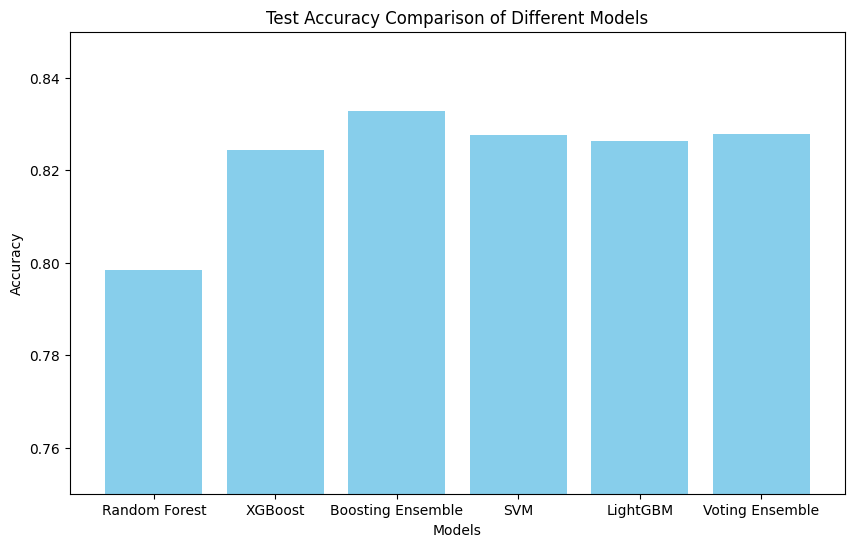

In [28]:
# Bar plot for test accuracy
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy, color='skyblue')
plt.title("Test Accuracy Comparison of Different Models")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.ylim(0.75, 0.85)
plt.show()


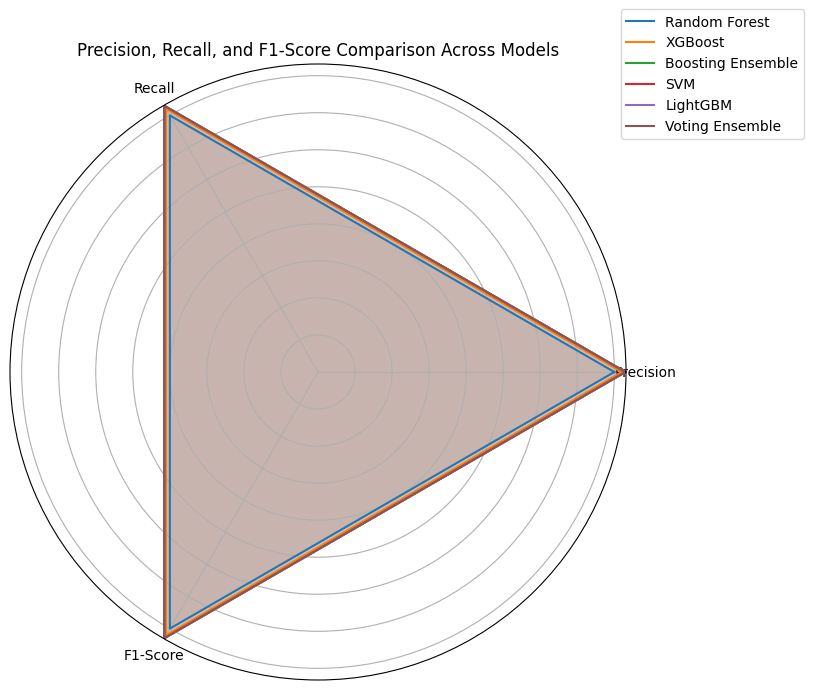

In [7]:
# Radar chart for precision, recall, and f1-score
metrics = ['Precision', 'Recall', 'F1-Score']
values = np.array([precision, recall, f1_score])
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Add the first angle to the end to close the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, model in enumerate(models):
    stats = values[:, i].tolist()
    stats += stats[:1]  # Repeat the first value to close the radar chart
    ax.plot(angles, stats, label=model)
    ax.fill(angles, stats, alpha=0.1)

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])  # Use only the original angles for labels
ax.set_xticklabels(metrics)
plt.title("Precision, Recall, and F1-Score Comparison Across Models")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

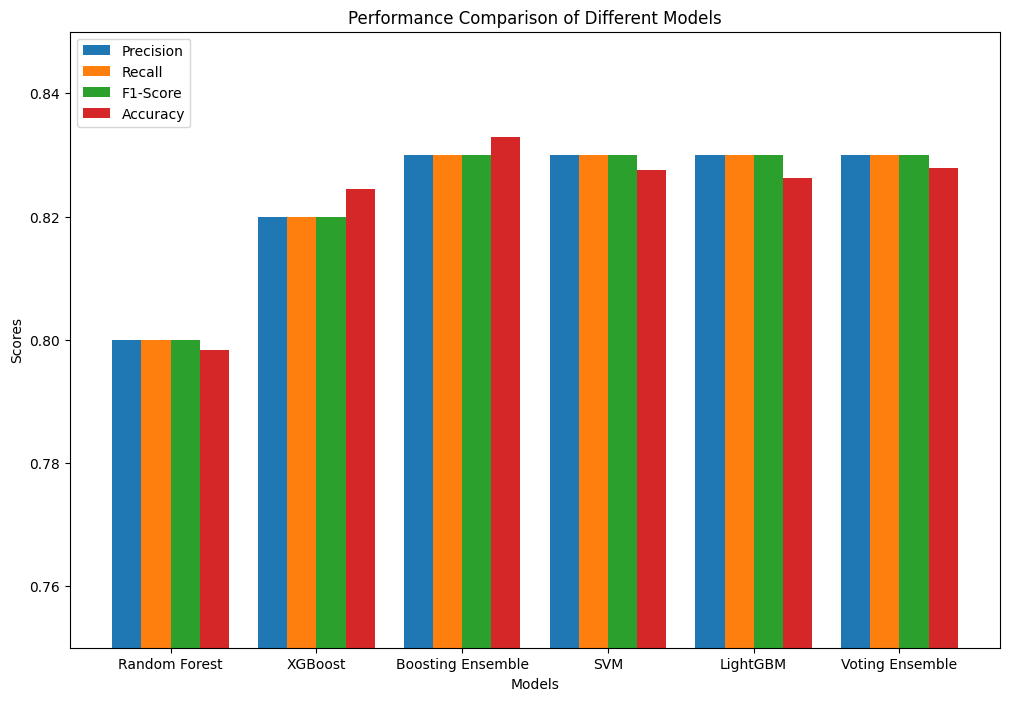

In [8]:
# Combine metrics into a single list for easy plotting
metrics = [precision, recall, f1_score, accuracy]
metric_names = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

# Set the width of each bar and position
bar_width = 0.2
x = np.arange(len(models))

# Plot the bar chart
plt.figure(figsize=(12, 8))

# Generate bars for each metric
for i, (metric, name) in enumerate(zip(metrics, metric_names)):
    plt.bar(x + i * bar_width, metric, width=bar_width, label=name)

# Customize the plot
plt.xlabel("Models")
plt.ylabel("Scores")
plt.title("Performance Comparison of Different Models")
plt.xticks(x + bar_width * 1.5, models)
plt.ylim(0.75, 0.85)  # Adjust as necessary
plt.legend(loc='upper left')

plt.show()


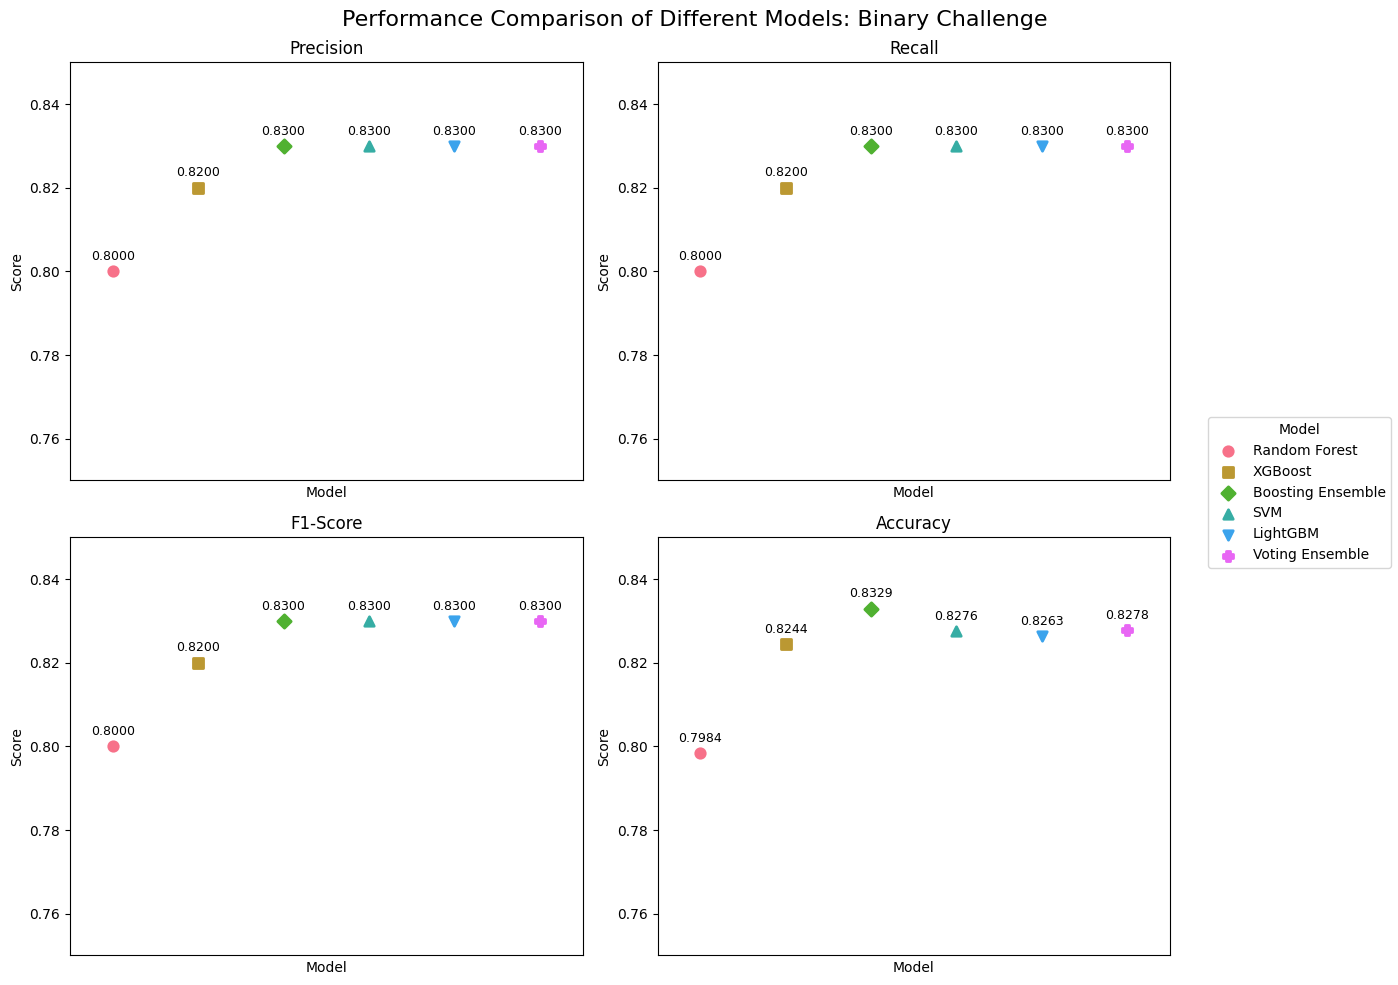

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the metrics for each model
models = ['Random Forest', 'XGBoost', 'Boosting Ensemble', 'SVM', 'LightGBM', 'Voting Ensemble']
accuracy = [0.7984, 0.8244, 0.8329, 0.8276, 0.8263, 0.8278]
precision = [0.80, 0.82, 0.83, 0.83, 0.83, 0.83]
recall = [0.80, 0.82, 0.83, 0.83, 0.83, 0.83]
f1_score = [0.80, 0.82, 0.83, 0.83, 0.83, 0.83]

# Prepare the data in a DataFrame for Seaborn
data = pd.DataFrame({
    'Model': models,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score,
    'Accuracy': accuracy
})

# Melt the DataFrame for easy plotting
data_melted = data.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Performance Comparison of Different Models: Binary Challenge', fontsize=16)

# Define markers and colors
markers = ['o', 's', 'D', '^', 'v', 'P']
palette = sns.color_palette("husl", len(models))

# Plot each metric in a different subplot without x-axis model names
for i, (metric, ax) in enumerate(zip(['Precision', 'Recall', 'F1-Score', 'Accuracy'], axs.flat)):
    sns.pointplot(
        data=data_melted[data_melted['Metric'] == metric], 
        x='Model', y='Score', hue='Model', 
        ax=ax, markers=markers, palette=palette
    )
    ax.set_title(metric)
    ax.set_ylim(0.75, 0.85)
    ax.set_xticks([])  # Remove x-axis model names

    # Suppress the individual subplot legends
    ax.get_legend().remove()

    # Annotate each point with the exact score
    for j, model in enumerate(models):
        score = data[metric][j]
        ax.text(j, score + 0.002, f'{score:.4f}', ha='center', va='bottom', fontsize=9)

# Add a single legend on the right side
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='Model')
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to fit the legend on the right
plt.show()


In [25]:
plt.savefig("result_binary.png")

<Figure size 640x480 with 0 Axes>